[View in Colaboratory](https://colab.research.google.com/github/neoaksa/Distracted_Driver_Detection/blob/master/Distracted_Driver_Detection.ipynb)

Distracted Driver images are from kaggle competiton which you can find detail [here](https://www.kaggle.com/c/state-farm-distracted-driver-detection#description).

Basicly, the data alrealy labeled into 10 different statues, from C0 to C9. 
- c0: normal driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger 

we know it is a supervised learning problem and there are bunch of solutions for this problem in kaggle. But I still want to implent it as I need to build a standard pipline for this kind of issue and try transfer learning by keras to achieve the best result basis of  multi-class logarithmic loss.   

**Step 1**: the first setp is simple, download the raw data from google drive and unzip the image folder. This might take a while since the image zip file are almost 4Gb. Compressed file :https://drive.google.com/file/d/1OA94GnqYDD9O4NPxepRot4-whIYYC62S/view?usp=sharing
 Plus: you will love Google componets, the uncompress process is super faster than your own pc.

In [0]:
# this will reset colab to inital status,inculds vm,  in case you need it.
# after running it, you should wait for around 1 mins(see status on top right)
# !kill -9 -1

In [1]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import auth
import zipfile

# authenticate google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')
# 1. Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def downloadFile(inputfilename,outputfilename):
    downloaded = drive.CreateFile({'id': inputfilename})
    # assume the file is called file.csv and it's located at the root of your drive
    downloaded.GetContentFile(outputfilename)
    
# traning file download. You can change ID by your own google drive shared link
FileObj = downloadFile("1OA94GnqYDD9O4NPxepRot4-whIYYC62S","all.zip")

# unzip files
zip_ref = zipfile.ZipFile('all.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()
# unzip images
zip_ref = zipfile.ZipFile('imgs.zip', 'r')
zip_ref.extractall('./imgs/')
zip_ref.close()

# check the dictory
import os
for x in os.listdir('./'):
    print(x)

    100% |████████████████████████████████| 993kB 6.6MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
.config
sample_data
driver_imgs_list.csv
adc.json
all.zip
sample_submission.csv
imgs
imgs.zip


So, we got the raw data we need. 
- *driver_imgs_list.csv* is the label information. 
- *imgs* is the folder for storing images by classifications
- *sample_submission.csv* is the submission format, we can leave it alone.

To understand more information about folder structure, and how it works with keras, please click [here](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720).

**Step 2**: Before we do any data analysis, we need to overview the whole dataset, such as distribution of samples or take a peek of images by each classification.

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64


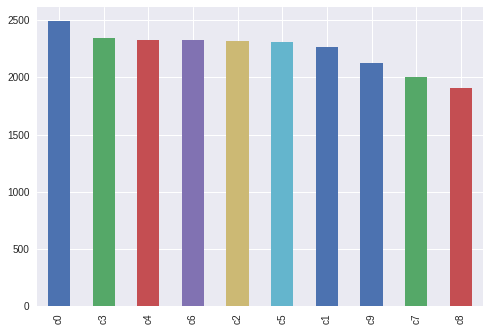

In [2]:
import pandas as pd

# load data from  driver_imgs_list.csv
df_all = pd.read_csv('driver_imgs_list.csv')
print(df_all['classname'].value_counts())
df_all['classname'].value_counts().plot(kind='bar')

The number of each category shows they are balance. Otherwise, wehave to rebalance samples by ADASYN or SMOTE.

Then I will create a validation folder by stratified splitting from training folder. The structure needs to adapt to the requirements of *ImageDataGenerator.flow_from_directory*.

In [4]:
import os
import shutil

# let's see how many samples in traing and testing folders
print('train sample #:'+ str(sum([len(files) for r, d, files in os.walk('./imgs/train')])))
print('test sample #:' + str(sum([len(files) for r, d, files in os.walk('./imgs/test')])))
# back up train folder
# shutil.copytree('./imgs/train','./imgs/train_copy')

# create validation folder from training folder
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_all['img'],
                                                    df_all['classname'],
                                                    stratify=df_all['classname'], 
                                                    test_size=0.25)
# move validation files from training folder
try: 
    # remove recursively
    shutil.rmtree('./imgs/validation/')
except:
    pass
finally:
    # create validation folders
    os.makedirs('./imgs/validation/')
    # create subclass folders
    for i in range(10):
       os.makedirs('./imgs/validation/c'+str(i))

# move files
for test_f, test_c in zip(X_test,y_test):
    try:
        file_name_from = './imgs/train/'+test_c+'/'+test_f
        file_name_dest = './imgs/validation/'+test_c+'/'+test_f
        shutil.move(file_name_from,file_name_dest)
    except:
        pass
    
print('validation sample #:' + str(sum([len(files) for r, d, files in os.walk('./imgs/validation')])))
print('train sample after spliting #:'+ str(sum([len(files) for r, d, files in os.walk('./imgs/train')])))

train sample #:22424
test sample #:79726
validation sample #:5606
train sample after spliting #:16818


**Step 3**: we will use a** Convolution Neural Network** for the task. However, we don't have to train a new VGG19 from begining. Alternatively, we will freeze 1-5 layer(cov layers), and only add our FC layers for training. The output is probability of each category by softmax.

In [6]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 48, 48
train_data_dir = './imgs/train'
validation_data_dir = './imgs/validation'
# nb_train_samples = 4125
# nb_validation_samples = 466 
batch_size = 16
epochs = 10

# VGG19 pre-trained model
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the first 5 layers(Cov layers), and only train FC layer
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom FC Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical",
color_mode = 'rgb')

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical",
color_mode = 'rgb')

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg19_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
history = model_final.fit_generator(
train_generator,
# samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
# nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 16818 images belonging to 10 classes.
Found 5606 images belonging to 10 classes.
Epoch 1/10
1052/1052 [==============================] - 174s 165ms/step - loss: 1.6681 - acc: 0.3515 - val_loss: 0.9458 - val_acc: 0.6359

Epoch 00001: val_acc improved from -inf to 0.63593, saving model to vgg19_1.h5
Epoch 2/10
1052/1052 [==============================] - 167s 159ms/step - loss: 0.7195 - acc: 0.7418 - val_loss: 0.3933 - val_acc: 0.8630

Epoch 00002: val_acc improved from 0.63593 to 0.86300, saving model to vgg19_1.h5
Epoch 3/10
1052/1052 [==============================] - 167s 159ms/step - loss: 0.3928 - acc: 0.8722 - val_loss: 0.5492 - val_acc: 0.8247

Epoch 00003: val_acc did not improve from 0.86300
Epoch 4/10
1052/1052 [==============================] - 168s 160ms/step - loss: 0.2562 - acc: 0.9196 - val_loss: 0.1418 - val_acc: 0.9586

Epoch 00004: val_acc improved from 0.86300 to 0.95862, saving model to vgg19_1.h5
Epoch 5/10
1052/1052 [==============================] - 165s 157

After simple 10 epoches, we reached almost 97% accurate. This result is good enough comparied the time we spend in training the model. Then we upload this model to google drive for future developing.

In [7]:
# upload file
# save to google drive folder:1S5ScWV_Mxb7jvx2JfKb2HybzdiitRbrR is id of sharefolder
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink","id": '1S5ScWV_Mxb7jvx2JfKb2HybzdiitRbrR'}]})
f.SetContentFile('vgg19_1.h5')
f.Upload()
print('Uploaded file with ID {}'.format(f.get('id')))

Uploaded file with ID 1GR2TVW_4dLtVtwIOqUq3EJ-96e9dVN9_


We can also have a visual peek of training history as blew.

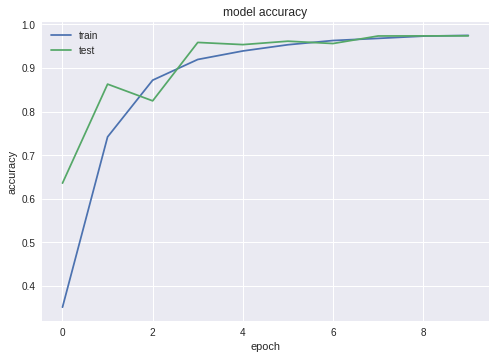

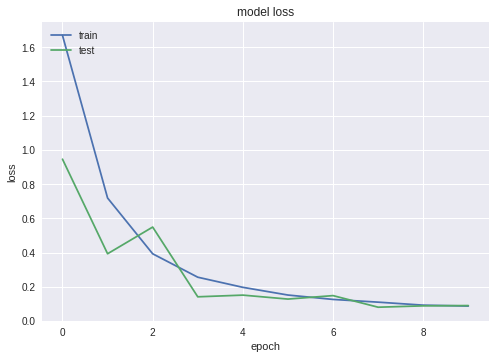

In [9]:
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# !pip install pydot-ng
# !pip install graphviz
# !apt-get install graphviz
# !pip install -q pydot 
# # if you need to restart runtime, you can run script blew to load model again
# # model_final = load_model('vgg19_1.h5')

# from keras.utils.vis_utils import plot_model
# plot_model(model_final, to_file='model.png')
# f = drive.CreateFile({"parents": [{"kind": "drive#fileLink","id": '1S5ScWV_Mxb7jvx2JfKb2HybzdiitRbrR'}]})
# f.SetContentFile('model.png')
# f.Upload()
# print('Uploaded image file with ID {}'.format(f.get('id')))

**Step 4**: Now, we have created our model already. Since kaggle didn't provide labels for test group, we cannot get a result from it. However, it is still possible to randomly pick some images to have our prediction testing.

orignal picture


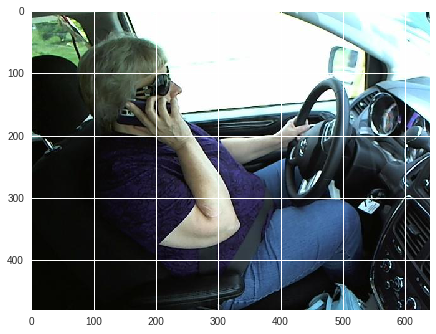

compressed picture


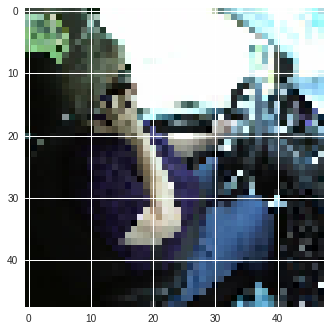

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import cv2
import numpy as np

test_file = []
for x in os.listdir('./imgs/test/'):
    test_file.append(x)


# randomly pick up images
print('orignal picture')
img=mpimg.imread('./imgs/test/' + random.choice(test_file))
imgplot = plt.imshow(img)
plt.show()

# down size
print('compressed picture')
res = cv2.resize(img, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
imgplot = plt.imshow(res)
plt.show()

# since I only use one image, I have to expend to 4D array with [1,48,48,3], the first dim means number of pictures
res = np.expand_dims(res, axis=0)
# model_final.summary()
model_final.predict(res)

Figure out C2=1, which is talking on the phone - right.